In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
tf.__version__

'2.1.0'

In [3]:
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

In [4]:
import pathlib

In [5]:
data_dir = r"G:\Jupyter-projects\NSFW-Classifier\data"

In [6]:
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'

In [7]:
test_path = pathlib.Path(test_path)
train_path = pathlib.Path(train_path)

In [8]:
test_image_count = len(list(test_path.glob('*/*.jpg')))
train_image_count = len(list(train_path.glob('*/*.jpg')))

In [9]:
print(test_image_count, train_image_count)

18968 79316


In [10]:
CLASS_NAMES = np.array([item.name for item in train_path.glob('*')])

In [11]:
CLASS_NAMES

array(['negative', 'positive'], dtype='<U8')

In [12]:
image_shape = (306, 306, 3)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
image_generator = ImageDataGenerator(rescale=1./255)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [16]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=image_shape))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 304, 304, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 302, 302, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 151, 151, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 128)     147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 147, 147, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 145, 145, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 64)        0

In [18]:
batch_size = 16

In [19]:
train_image_gen = image_generator.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 79316 images belonging to 2 classes.


In [20]:
test_image_gen = image_generator.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 18968 images belonging to 2 classes.


In [21]:
train_image_gen.class_indices

{'negative': 0, 'positive': 1}

In [22]:
test_image_gen.class_indices

{'negative': 0, 'positive': 1}

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy',patience=2)

In [24]:
from datetime import datetime
log_directory = 'logs\\{}'.format(datetime.now().strftime("%Y-%m-%d--%H%M"))

t_board = TensorBoard(log_dir=log_directory, histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)

In [25]:
# results = model.fit(train_image_gen,epochs=16, validation_data=test_image_gen, callbacks=[early_stop])
results = model.fit(train_image_gen,epochs=16, validation_data=test_image_gen, verbose=1, callbacks=[t_board])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4958 steps, validate for 1186 steps
Epoch 1/16
4958/4958 [==============================] - 1825s 368ms/step - loss: 0.2623 - accuracy: 0.8939 - val_loss: 0.0887 - val_accuracy: 0.9654
Epoch 2/16
4958/4958 [==============================] - 1711s 345ms/step - loss: 0.0841 - accuracy: 0.9701 - val_loss: 0.0200 - val_accuracy: 0.9934
Epoch 3/16
4958/4958 [==============================] - 1652s 333ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0075 - val_accuracy: 0.9976
Epoch 4/16
4958/4958 [==============================] - 1616s 326ms/step - loss: 0.0088 - accuracy: 0.9975 - val_loss: 0.0066 - val_accuracy: 0.9980
Epoch 5/16
4958/4958 [==============================] - 1635s 330ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0034 - val_accuracy: 0.9987
Epoch 6/16
4958/4958 [==============================] - 1518s 306ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0099 - val_accuracy: 0.9964
Epoch 7/16

In [26]:
model.save('models/nsfw_classifier_v9.h5')

In [27]:
import pandas as pd

In [28]:
losses = pd.DataFrame(model.history.history)

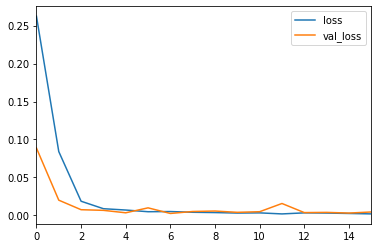

In [29]:
losses[['loss','val_loss']].plot()

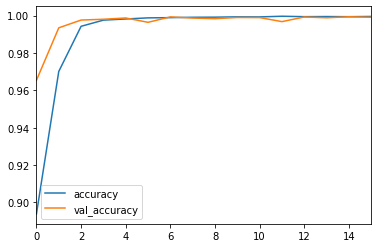

In [30]:
losses[['accuracy','val_accuracy']].plot()

In [31]:
model.metrics_names

['loss', 'accuracy']

In [32]:
model.evaluate(test_image_gen)

  ...
    to  
  ['...']
1186/1186 [==============================] - 127s 107ms/step - loss: 0.0045 - accuracy: 0.9991


[0.0044798319729528364, 0.99905103]

In [33]:
pred_probabilities = model.predict(test_image_gen)

In [34]:
pred_probabilities

array([[5.7888631e-37],
       [4.6036037e-24],
       [1.5359316e-32],
       ...,
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [35]:
predictions = pred_probabilities > 0.5

In [36]:
from sklearn.metrics import classification_report,confusion_matrix

In [37]:
confusion_matrix(test_image_gen.classes, predictions)

array([[9394,    4],
       [  14, 9556]], dtype=int64)

![caption](images/Confusion_Matrix6.png)

In [ ]:
import cv2

In [ ]:
size = 306

In [ ]:
test_pos = r"G:/Jupyter-projects/NSFW-Classifier/new_tests/old/test_pos.jpg"
test_neg = r"G:/Jupyter-projects/NSFW-Classifier/new_tests/old/test_neg.jpg"

In [ ]:
test_pos_img = cv2.imread(test_pos, cv2.IMREAD_UNCHANGED)
test_neg_img = cv2.imread(test_neg, cv2.IMREAD_UNCHANGED)

In [ ]:
img_pos = cv2.resize(test_pos_img, (size, size))
img_neg = cv2.resize(test_neg_img, (size, size))

In [ ]:
img_pos.shape

In [ ]:
img_neg.shape

In [ ]:
img_pos = np.expand_dims(img_pos, axis=0)
img_neg = np.expand_dims(img_neg, axis=0)

In [ ]:
img_pos.shape

In [ ]:
model.predict(img_pos) > 0.5

In [ ]:
test = r"G:/Jupyter-projects/NSFW-Classifier/new_tests/j.jpg"
test_img = cv2.imread(test, cv2.IMREAD_UNCHANGED)
test_img_re = cv2.resize(test_img, (size, size), interpolation=cv2.INTER_AREA)
print(test_img.shape)
test_img = np.expand_dims(test_img_re, axis=0)
print(test_img.shape)
raw = model.predict(test_img)
result = raw > 0.5
print("? : {}, Raw score : {}".format(result, raw))
plt.imshow(test_img_re)